Ejemplo de FALSE TASK para entrenar un embedding. La false task es el entrenamiento de un modelo para que cumpla una tarea la cual no es el objetivo final del programador. En este caso la false task es adividar la siguiente palabra a partir de un número dado (`CONTEXT_SIZE`) de palabras previas. El objetivo real es aprender un word_embedding de las palabras del texto a procesar.

In [5]:
# Librerias necesarias
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

torch.manual_seed(1)

In [9]:
# defino las variables del contexto para predecir la siguiente palabra y la 
# dimension del embedding

CONTEXT_SIZE = 2
EMBEDDING_DIM = 10


# texto a procesar
test_sentence = """he is a king
     she is a queen
     he is a man
     she is a woman
     the queen is a woman
     the king is a man
     warsaw is poland capital
     berlin is germany capital
     paris is france capital""".split()


# we should tokenize the input, but we will ignore that for now
# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]

# Print the first 3, just so you can see what they look like.
print('algunas NGRAMS de CONTEXT y PALABRA_OBJETIVO')
print(ngrams[:3])

corpus = test_sentence
vocab = set(itertools.chain.from_iterable(corpus))
vocab = set(corpus)
# Armo un diccionario de index para todo el vocabulario de mi texto a procesar.
# Cada palabra tendrá una entrada en dicho diccionario (un número) el cual 
# cohincidirá con la primera dimensión del embedding (nro de filas).

word_to_ix = {word: i for i, word in enumerate(vocab)}

print('diccionario de vocabulario')
word_to_ix

algunas NGRAMS de CONTEXT y PALABRA_OBJETIVO
[(['is', 'he'], 'a'), (['a', 'is'], 'king'), (['king', 'a'], 'she')]
diccionario de vocabulario


{'a': 13,
 'berlin': 7,
 'capital': 14,
 'france': 10,
 'germany': 11,
 'he': 12,
 'is': 9,
 'king': 0,
 'man': 4,
 'paris': 6,
 'poland': 1,
 'queen': 3,
 'she': 8,
 'the': 15,
 'warsaw': 5,
 'woman': 2}

In [10]:
# Creamos la clase de la NN... en este caso está el embedding seguido de unas
# FC.
# Observar que el autor de este código, colocó las funciones de no linealidad
# solo en el forward.
# la función softmax final es por que queremos adivinar la proxima palabra
# y lo queremos hacer como una probabilidad.

class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 256)
        self.linear2 = nn.Linear(256, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(100):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

# To get the embedding of a particular word, e.g. "beauty"
# print(model.embeddings.weight[word_to_ix["beauty"]])

[97.16304075717926, 75.3261244893074, 62.45232132077217, 53.71491304039955, 47.19042633473873, 42.09229773283005, 37.98500369489193, 34.63394870609045, 31.882005587220192, 29.60279005765915, 27.706417739391327, 26.119738705456257, 24.78516625240445, 23.65591052174568, 22.69996584765613, 21.87374405004084, 21.164122745394707, 20.546537812799215, 20.006135914474726, 19.53556683473289, 19.116644201800227, 18.743569439277053, 18.41226067394018, 18.114021506160498, 17.841647213324904, 17.599038903601468, 17.37968224659562, 17.17631197348237, 16.98983656335622, 16.818014594726264, 16.659707417711616, 16.51306354533881, 16.37857791548595, 16.249547439161688, 16.132607859093696, 16.022631756030023, 15.920433284249157, 15.82332059321925, 15.730709817726165, 15.642428658902645, 15.561596229672432, 15.48422972066328, 15.414291160181165, 15.342267683707178, 15.277069587726146, 15.21020197076723, 15.150515463901684, 15.092380250338465, 15.036910814233124, 14.981456501409411, 14.928930566413328, 14.

In [16]:
emb_vocab=torch.empty((1,EMBEDDING_DIM))
model.eval
for wordi in vocab:
  #print(wordi)
  #aver = make_context_vector([wordi], word_to_ix)
  embedi = model.embeddings.weight[word_to_ix[wordi]]
  emb_vocab = torch.cat((emb_vocab, embedi.unsqueeze(0)),0)
print('Embedding')
print('dimensiones: [vocab_size x EMBEDDING_DIM]')
print(emb_vocab.shape)

Embedding
dimensiones: [vocab_size x EMBEDDING_DIM]
torch.Size([17, 10])


In [17]:
print('largo del vocabulario: ',len(vocab))
print(type(emb_vocab))
emb_vocab = emb_vocab[1:]
print('shape del embedding vocab: ', emb_vocab.shape)


largo del vocabulario:  16
<class 'torch.Tensor'>
shape del embedding vocab:  torch.Size([16, 10])


In [19]:
# reducimos el embedding a 3D para poder plotearlo
completo = emb_vocab.detach().numpy()
print('tamaño completo: ', completo.shape)
pca = PCA(n_components=3)
reducido = pca.fit(completo).transform(completo)
print('tamaño reducido: ', reducido.shape)
x = reducido[:,0]
y = reducido[:,1]
z = reducido[:,2]

tamaño completo:  (16, 10)
tamaño reducido:  (16, 3)


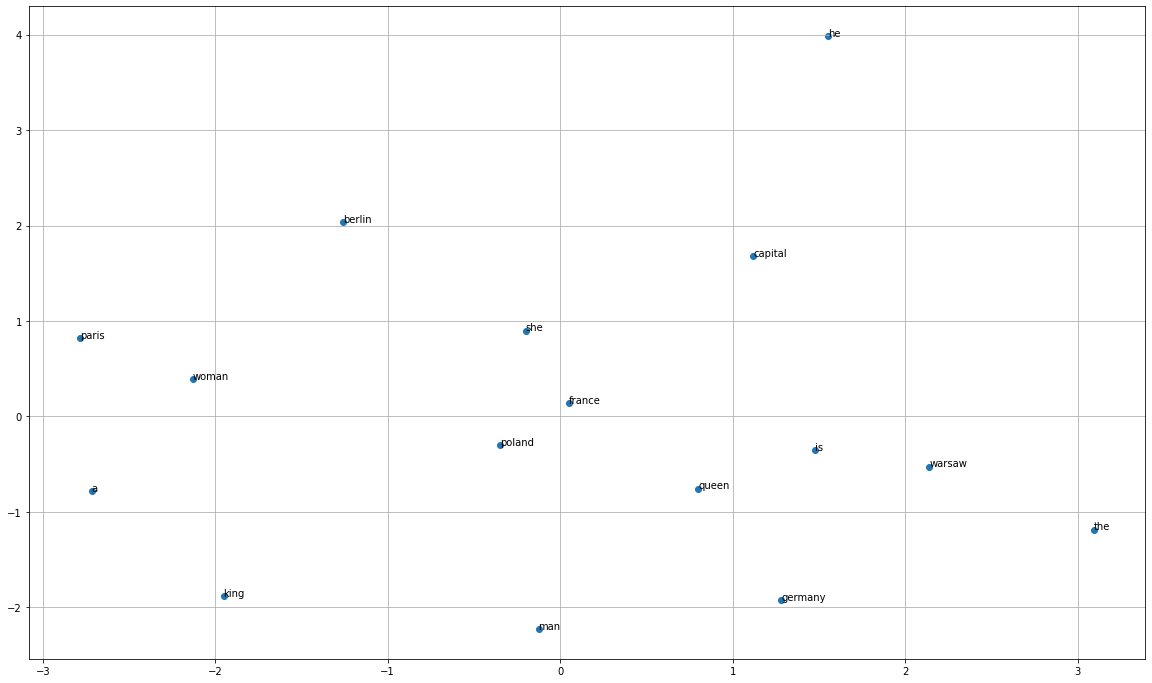

In [20]:
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(x, y)
plt.grid()
#ax.scatter(completo[:,0], completo[:,1])
# Show the boundary between the regions:
for i, txt in enumerate(vocab):
    ax.annotate(txt, (x[i], y[i]))
#plt.xlim((-20,10))
plt.show()
